**Efeito de $\epsilon$**

> Observação: Para **ver efeito de $\epsilon$**, não podemos utilizar N=1 (pois o termo médio cancela); Dessa forma acompanhamos **um índice i** dentro de um sistema com $N \gg 1$

# Explorador de um mapa (dentro do conjunto) -- Séries, $I_{\pm}$ e Lyapunov

## Imports & Setups

In [1]:
import os, json, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
# garante que o pacote local seja enxergado (repo/notebooks -> adicionar o diretório pai)
sys.path.append(os.path.dirname(os.getcwd()))

from gcm.core import Config, GloballyCoupledMaps
from gcm.maps import bistable_intervals

FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(exist_ok=True, parents=True); DATA.mkdir(exist_ok=True, parents=True)

MU = 1.9
EPS_LIST = [0.2, 0.7, 1.1, 1.6]  # representativos
N = 1024
T_BURN = 600
T_MEAS = 600
I = 0  # índice observado

## Resultados e plots

In [3]:
# Simulação e coleta de séries

def simulate_trace(mu, eps, N, T_burn, T_meas, idx=0, seed=2025):
    cfg = Config(N=N, eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.reset(init="half_half")
    sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)
    return traj[:, idx], sys.x.copy()

traces = {}
final_x = {}
for eps in EPS_LIST:
    y, xf = simulate_trace(MU, eps, N, T_BURN, T_MEAS, idx=I)
    traces[eps] = y
    final_x[eps] = xf

# salva dicionário com estatísticas básicas
stats = {float(eps): {
    "mean": float(np.mean(y)),
    "std": float(np.std(y)),
    "min": float(np.min(y)),
    "max": float(np.max(y)),
} for eps, y in traces.items()}
(DATA/"single_index_traces_stats.json").write_text(json.dumps(stats), encoding="utf-8")

488

<function matplotlib.pyplot.show(close=None, block=None)>

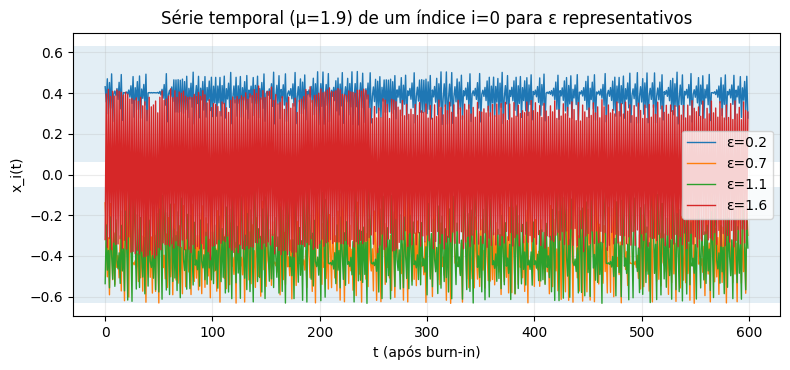

In [5]:
# Plot das séries + Intervalos I+-
i_minus, i_plus = bistable_intervals(MU)

fig, ax = plt.subplots(figsize=(8,3.8))
for eps, y in traces.items():
    ax.plot(y, lw=1.0, label=f"ε={eps}")
# faixas I±
ax.axhspan(i_minus[0], i_minus[1], alpha=0.12)
ax.axhspan(i_plus[0], i_plus[1], alpha=0.12)
ax.set_xlabel("t (após burn-in)"); ax.set_ylabel("x_i(t)")
ax.set_title(f"Série temporal (μ={MU}) de um índice i={I} para ε representativos")
ax.grid(alpha=0.25); ax.legend()
fig.tight_layout(); fig.savefig(FIGS/"TS_single_index_rep.png", dpi=180); 
plt.show #plt.close(fig)

In [7]:
# Lyapunov local (checagem numérica)

# Derivada por partes: mu no miolo |x|<1/3, -mu nas abas

def fp(x, mu):
    return np.where(np.abs(x) < 1.0/3.0, mu, -mu)

lts = {}
for eps, y in traces.items():
    # aproxima λ_local por média temporal de ln|f'(x_t)|
    lam = float(np.mean(np.log(np.abs(fp(y, MU)))))
    lts[eps] = lam

print("λ_local teórico = ln|μ| =", np.log(abs(MU)))
print("Estimativas por ε:", lts)
(DATA/"finite_time_lyapunov_single_index.json").write_text(json.dumps({str(k): v for k,v in lts.items()}), encoding="utf-8")

λ_local teórico = ln|μ| = 0.6418538861723947
Estimativas por ε: {0.2: 0.6418538861723946, 0.7: 0.6418538861723946, 1.1: 0.6418538861723946, 1.6: 0.6418538861723946}


108

<function matplotlib.pyplot.show(close=None, block=None)>

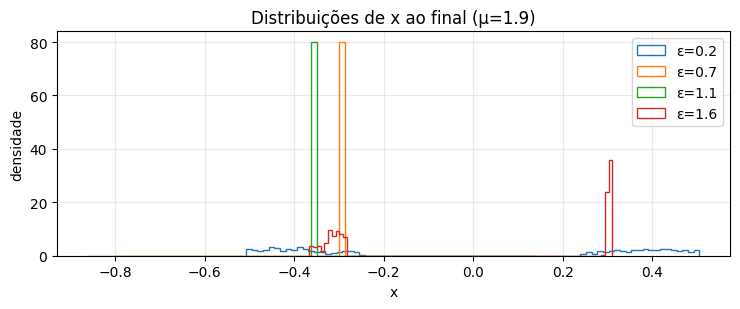

In [8]:
# Histogramas finais de x para comparar regimes
fig, ax = plt.subplots(figsize=(7.5,3.2))
for eps, x in final_x.items():
    ax.hist(x, bins=80, histtype='step', density=True, label=f"ε={eps}")
ax.set_xlabel("x"); ax.set_ylabel("densidade")
ax.set_title(f"Distribuições de x ao final (μ={MU})")
ax.grid(alpha=0.25); ax.legend()
fig.tight_layout(); fig.savefig(FIGS/"Hist_x_final_mu1.9.png", dpi=180); 
plt.show #plt.close(fig)
